In [13]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE

In [14]:
# Initialize some parameters

useful_data_cols = ['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed',
                    'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million',
                    'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million',
                    'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate',
                    'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older',
                    'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence',
                    'hospital_beds_per_thousand', 'life_expectancy',
                    'human_development_index']  # perc[perc>0.8].axes[0].tolist()

national_cols = ['location', 'date', 'population', 'population_density', 'median_age', 'aged_65_older',
                 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence',
                 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
                 'life_expectancy', 'human_development_index', 'excess_mortality', 'total_cases', 'total_cases_per_million',
                 'total_deaths_per_million', 'total_tests', 'total_tests_per_thousand', 'tests_per_case',
                 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred']

new_national_cols = ['population', 'population_density', 'median_age', 'aged_65_older',
                     'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
                     'diabetes_prevalence', 'female_smokers', 'male_smokers', 'total_smokers', 'handwashing_facilities',
                     'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index',  # 'excess_mortality',
                     'total_tests_per_thousand', 'tests_per_case', 'positive_rate', 'people_vaccinated_per_hundred',
                     'people_fully_vaccinated_per_hundred']

corr_features = ['median_age', 'female_smokers', 'male_smokers', 'cardiovasc_death_rate', 'diabetes_prevalence',
                 'hospital_beds_per_thousand']

case_death_cols = ['total_cases_per_million', 'total_deaths_per_million', 'death_rate', 'positive_rate']

In [15]:
# import data

data = pd.read_csv("owid-covid-data.csv").dropna(subset=useful_data_cols)
 
# Convert date from string to datetime
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [16]:
# National data analysis
cases_df = data.loc[data.groupby('location')['total_cases'].idxmax()]
cases_df = cases_df[cases_df['date'] >= datetime.strptime('2021-05-19', '%Y-%m-%d')]
national_df = data.loc[data[data['date'] == datetime.strptime('2021-05-19', '%Y-%m-%d')].groupby('location')['total_cases'].idxmax()]
national_df = national_df[national_df['location'].isin(cases_df['location'].tolist())]

# Some cleanings according to the feature outliers
national_df = national_df[national_df['location'] != 'Peru']

# Define new features and metrics
national_df['death_rate'] = \
    100*(national_df['total_deaths_per_million']/national_df['total_cases_per_million'])

# Share of smokers both male and female
national_df['total_smokers'] = national_df['female_smokers'] + national_df['male_smokers']

national_df['pos_rate'] = 100*(national_df['total_cases']/national_df['total_tests'])

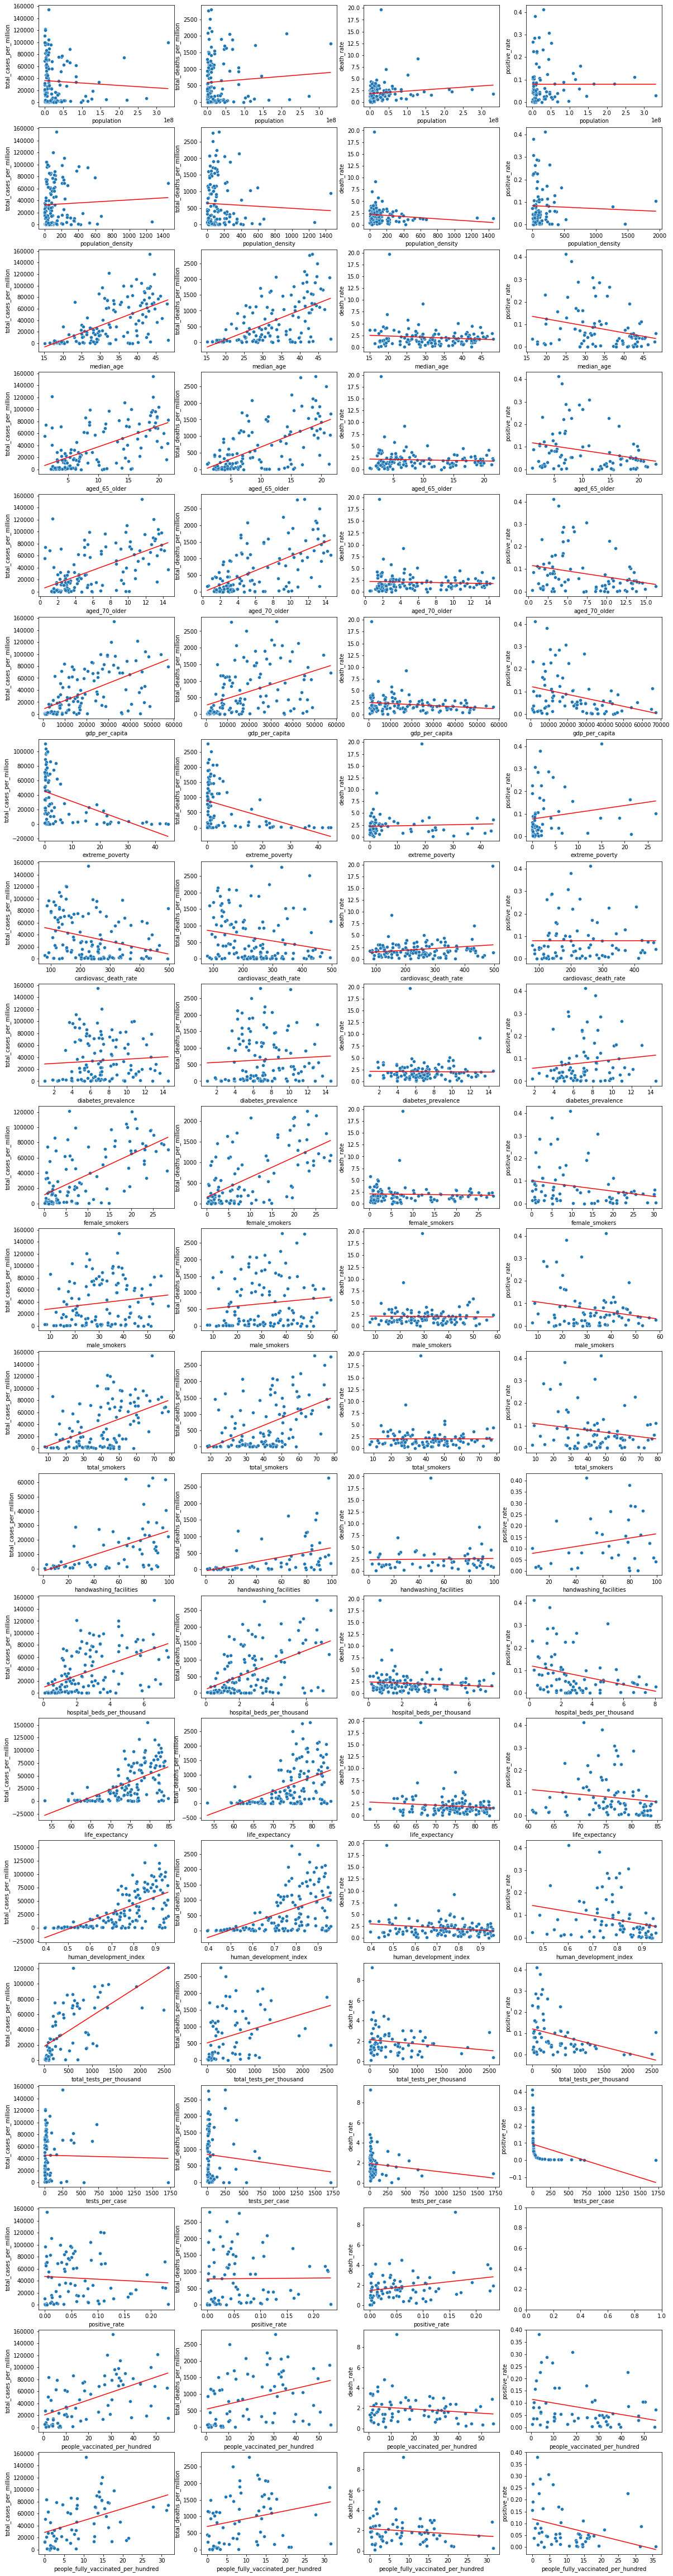

In [17]:
# Visualizing cases/deaths vs society-related features (one by one)
fig, axs = plt.subplots(len(new_national_cols), len(case_death_cols))
fig.set_size_inches(20, 84)
for i, prop in enumerate(new_national_cols):
    for j, nums in enumerate(case_death_cols):
        if nums == prop:
            continue
        new_df = national_df[[prop, nums]].copy().dropna()
        # Eliminating outliers
        new_df = new_df[new_df[prop] < new_df[prop].mean() + 2*new_df[prop].std()]
        
        # Line regression
        reg = LinearRegression().fit(new_df[prop].to_numpy().reshape(-1, 1), new_df[nums])
        min_prop = new_df[prop].min()
        max_prop = new_df[prop].max()
        prop_linspace = np.linspace(min_prop, max_prop, 10).reshape(-1, 1)
        pred_nums = reg.predict(prop_linspace)
        axs[i, j].plot(prop_linspace, pred_nums, 'r')
        
        # Scatter plot
        sns.scatterplot(y=nums, x=prop, data=new_df, ax=axs[i, j])

<AxesSubplot:>

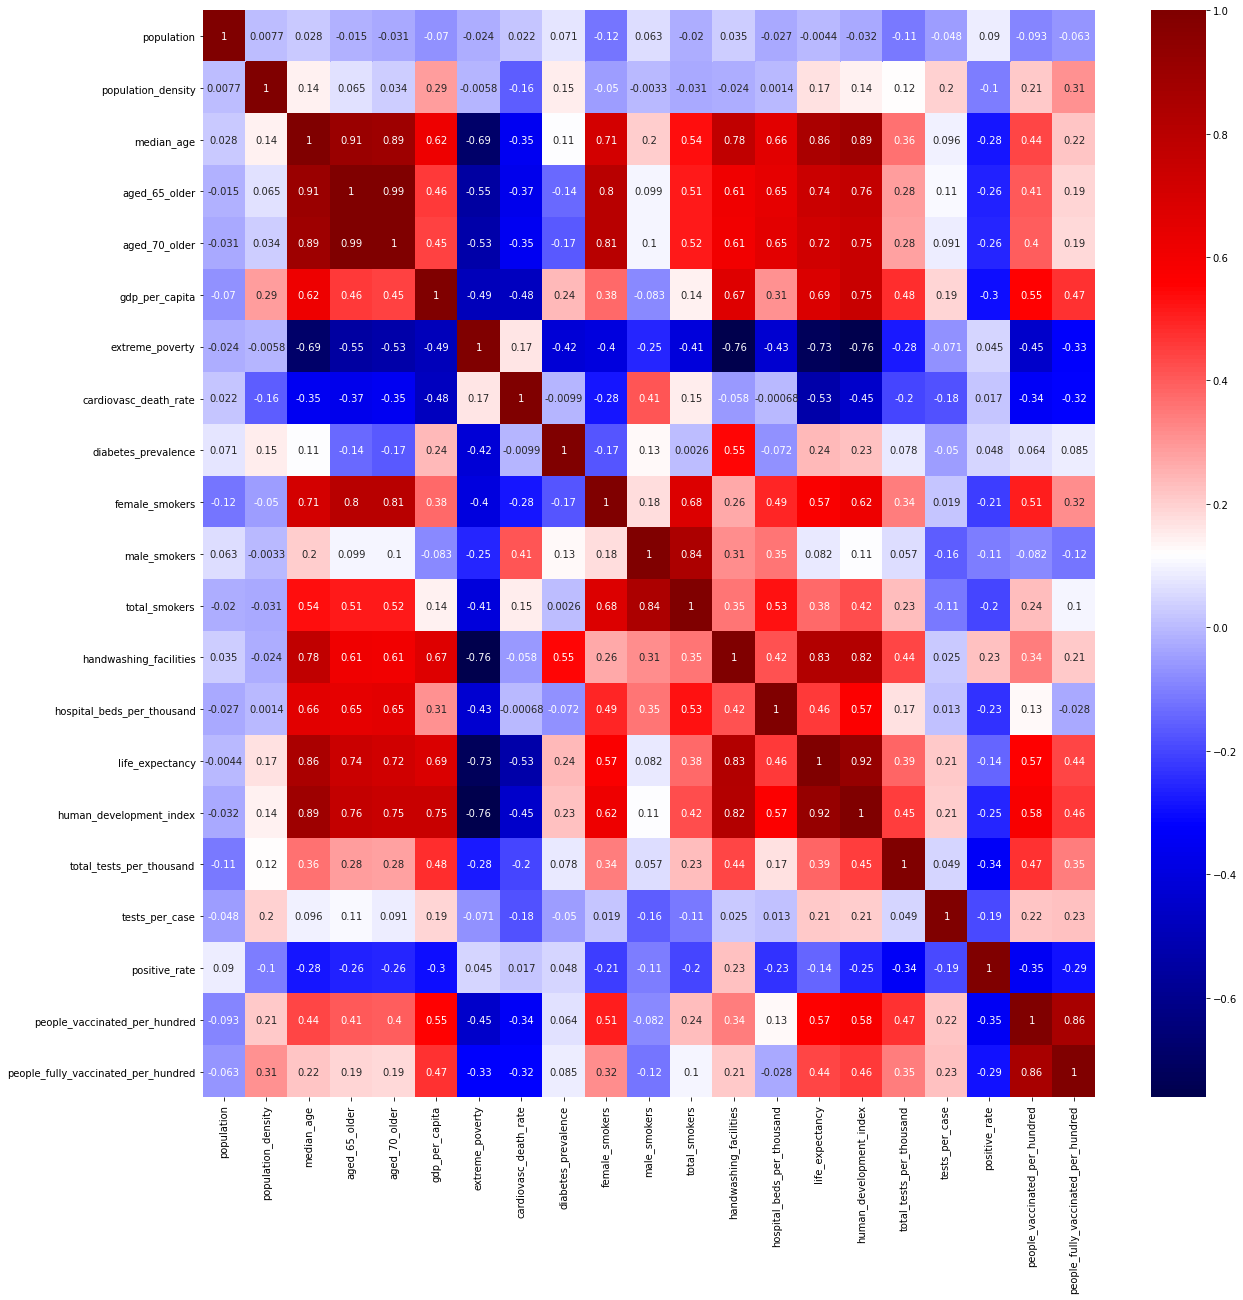

In [18]:
# Correlation analysis

nat_corr = national_df[new_national_cols].corr()
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(ax=ax, data=nat_corr, annot=True, cmap='seismic')

<AxesSubplot:>

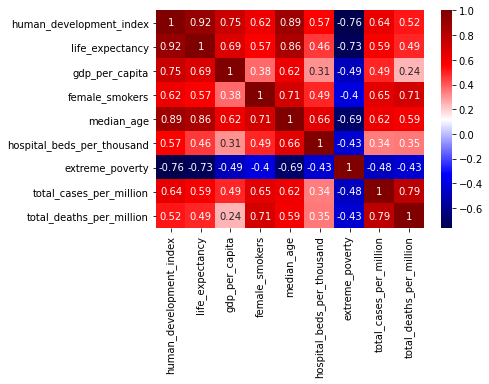

In [19]:
corr_age = national_df[['human_development_index', 'life_expectancy', 'gdp_per_capita', 'female_smokers', 'median_age', 'hospital_beds_per_thousand',
             'extreme_poverty', 'total_cases_per_million', 'total_deaths_per_million']].corr()
sns.heatmap(data=corr_age, annot=True, cmap='seismic')

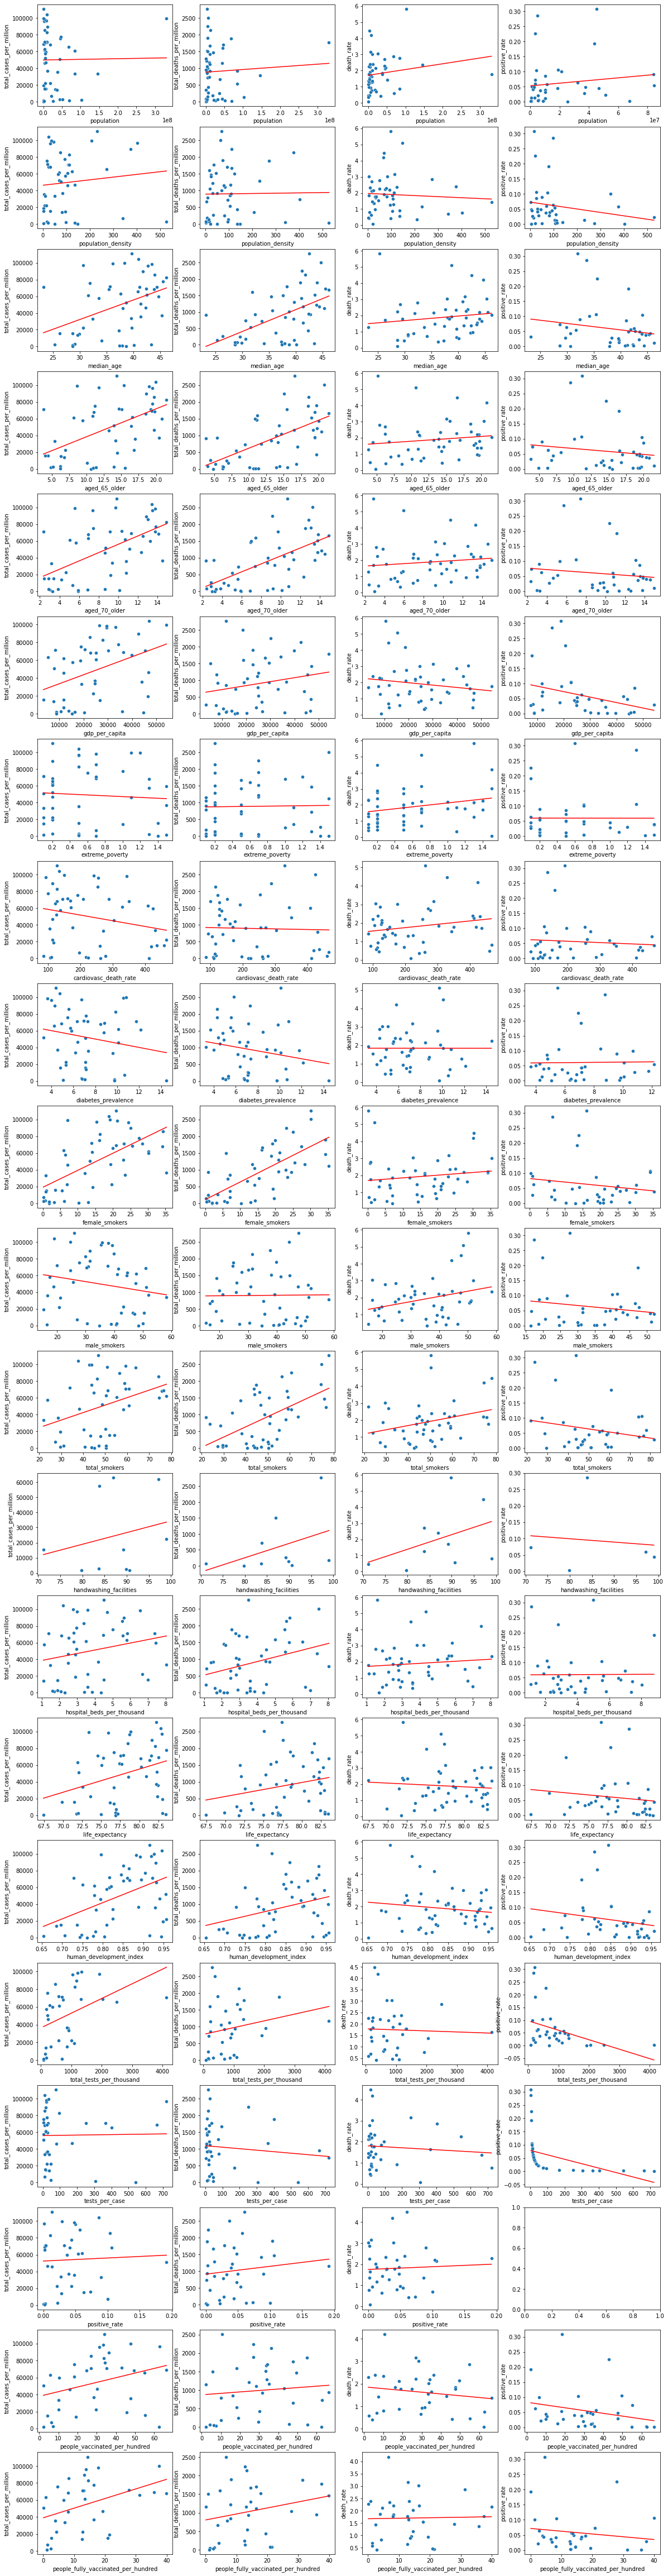

In [20]:
# Plot scatters for coutries with least extreme poverty
national_50_df = national_df[national_df['extreme_poverty']<=national_df['extreme_poverty'].median()].copy()
# Visualizing cases/deaths vs society-related features
fig, axs = plt.subplots(len(new_national_cols), len(case_death_cols))
fig.set_size_inches(20, 84)
for i, prop in enumerate(new_national_cols):
    for j, nums in enumerate(case_death_cols):
        if nums == prop:
            continue
        new_df = national_50_df[[prop, nums]].copy().dropna()
        # Eliminating outliers
        new_df = new_df[new_df[prop] < new_df[prop].mean() + 2*new_df[prop].std()]
        
        # Line regression
        reg = LinearRegression().fit(new_df[prop].to_numpy().reshape(-1, 1), new_df[nums])
        min_prop = new_df[prop].min()
        max_prop = new_df[prop].max()
        prop_linspace = np.linspace(min_prop, max_prop, 10).reshape(-1, 1)
        pred_nums = reg.predict(prop_linspace)
        axs[i, j].plot(prop_linspace, pred_nums, 'r')
        
        # Scatter plot
        sns.scatterplot(y=nums, x=prop, data=new_df, ax=axs[i, j])

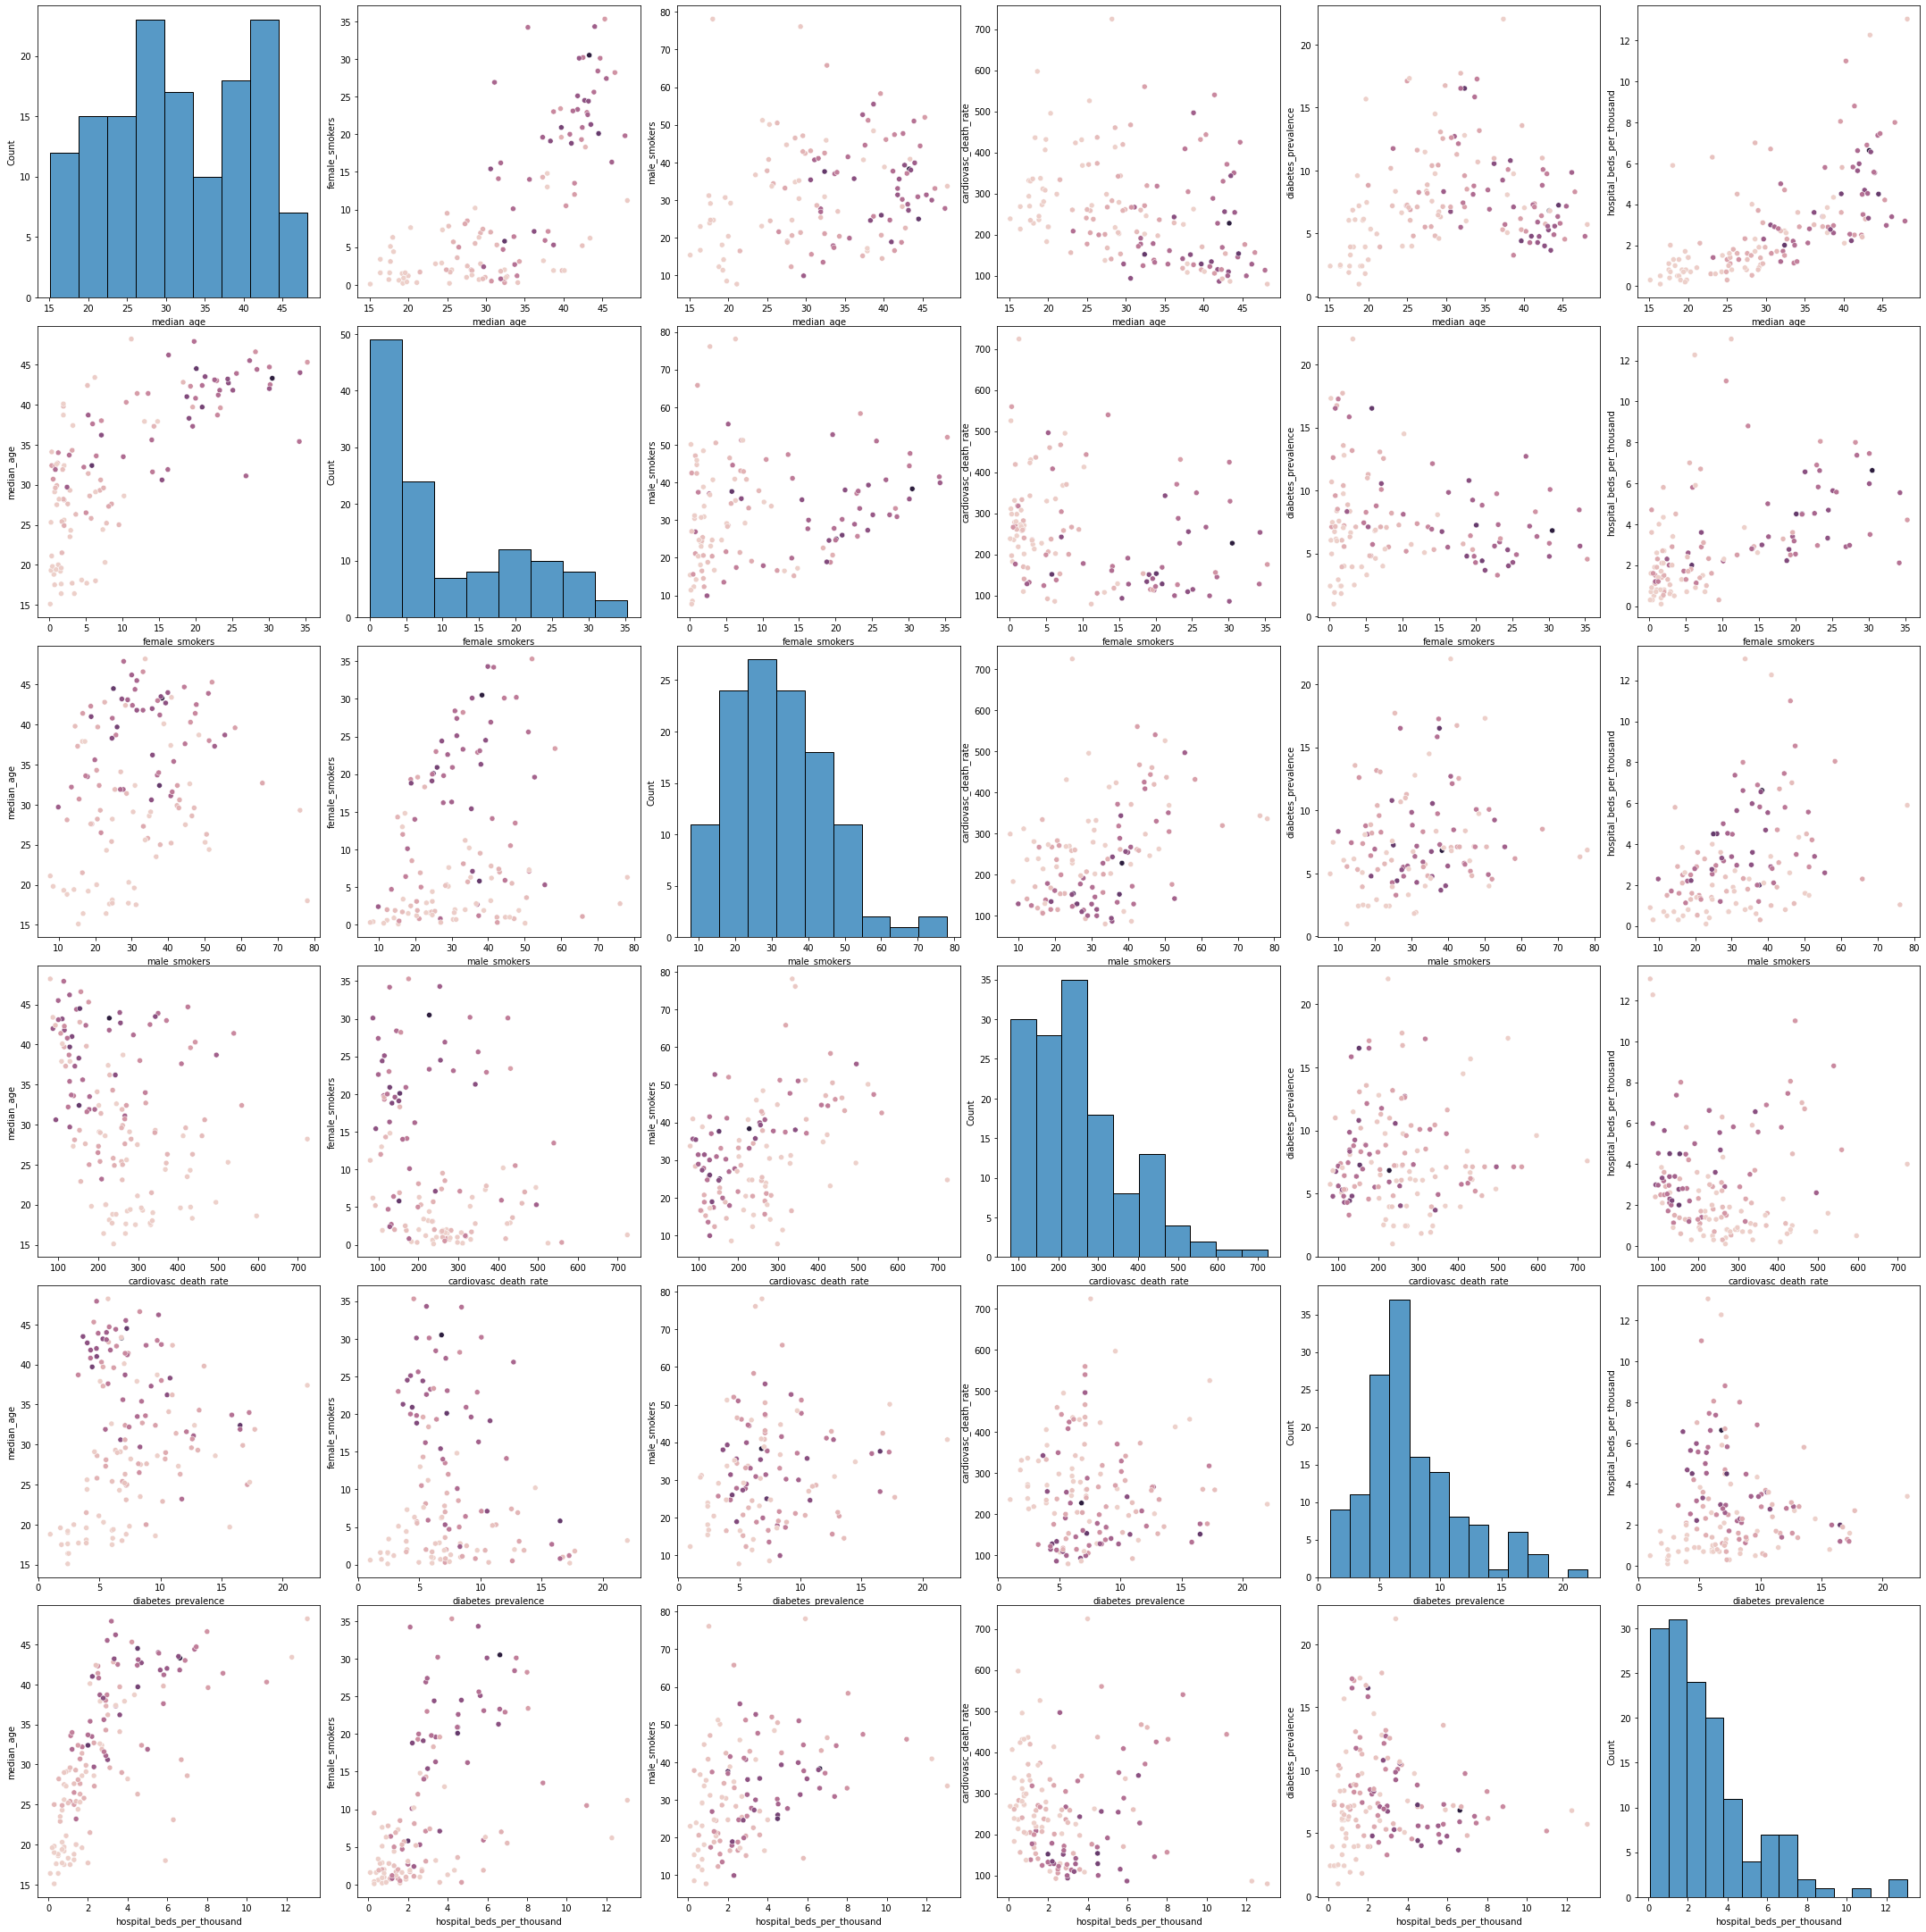

In [21]:
num_features = len(corr_features)
fig, ax = plt.subplots(num_features, num_features, figsize=(30, 30))
fig.tight_layout()

for i, feature1 in enumerate(corr_features):
    for j, feature2 in enumerate(corr_features):
        if i == j:  # diagonal
            sns.histplot(national_df[feature1], ax=ax[i][j])
        else:  # off diagonal
            sns.scatterplot(x=national_df[feature1], y=national_df[feature2],
                            ax=ax[i][j], hue=national_df['total_cases_per_million'],
                            # palette='BrBG',
                            legend=False)